In [1]:
import numpy as np
from matplotlib import pyplot as plt
import re
from nltk.corpus import stopwords

import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model

Using Theano backend.


In [2]:
f = open('../datasets/input.txt')
text = f.read()
f.close()

In [3]:
data = text[3433:]

data = data.lower()
data = re.sub('[^A-Za-z]+', ' ', data)
data = data.split()

stop_words = stopwords.words('english')
data = [word for word in data if word not in stop_words] # To drastically reduce the size of X

In [4]:
len(data)

261745

In [5]:
vocabulary, counts = np.unique(data, return_counts=True)
vocabulary.shape, counts.shape

((17628,), (17628,))

In [6]:
vocabulary, counts = vocabulary[counts > 2], counts[counts > 2]
vocabulary.shape, counts.shape

((8756,), (8756,))

In [7]:
(vocabulary == "bag").argmax()

565

In [8]:
def get_one_hot_vector(word):
    vec = np.zeros((vocabulary.shape[0], ))
    index = (vocabulary == word).argmax()
    vec[index] = 1
    return vec

In [9]:
get_one_hot_vector("bag").argmax()

565

In [10]:
dataset = []
for word in data:
    dataset.append(get_one_hot_vector(word))
dataset = np.asarray(dataset)
dataset.shape

(261745, 8756)

In [11]:
for i in range(10):
    print (vocabulary[dataset[i].argmax()])

year
took
degree
doctor
medicine
university
london
proceeded
aback
go


In [12]:
X = np.zeros((dataset.shape[0]-1, dataset.shape[1]*2))

for i in range(X.shape[0]-1):
    X[i] = np.hstack((dataset[i], dataset[i+1]))

In [13]:
y = dataset[1:]

In [14]:
X.shape, y.shape

((261744, 17512), (261744, 8756))

In [15]:
split = int(0.85 * X.shape[0])

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((222482, 17512), (39262, 17512), (222482, 8756), (39262, 8756))

In [16]:
embedding = 300

inp = Input(shape=(17512,))
emb = Dense(embedding, activation='tanh')(inp)
emb = Dropout(0.4)(emb)
out = Dense(8756, activation='softmax')(emb)

model = Model(inputs=inp, outputs=out)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

encoder = Model(inputs=inp, outputs=emb)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17512)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               5253900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8756)              2635556   
Total params: 7,889,456
Trainable params: 7,889,456
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist = model.fit(X_train, y_train,
                epochs=3,
                shuffle=False,
                batch_size=1024,
                validation_data=(X_test, y_test))

Train on 222482 samples, validate on 39262 samples
Epoch 1/3
222482/222482 [==============================] - 305s 1ms/step - loss: 6.9401 - acc: 0.1717 - val_loss: 4.9208 - val_acc: 0.4134
Epoch 2/3
222482/222482 [==============================] - 287s 1ms/step - loss: 3.6017 - acc: 0.6162 - val_loss: 2.7934 - val_acc: 0.7623
Epoch 3/3
222482/222482 [==============================] - 298s 1ms/step - loss: 2.1305 - acc: 0.8298 - val_loss: 1.9262 - val_acc: 0.8697


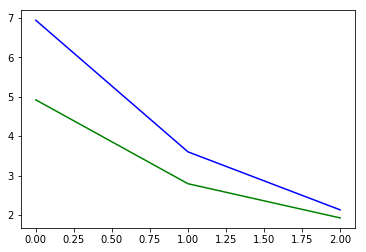

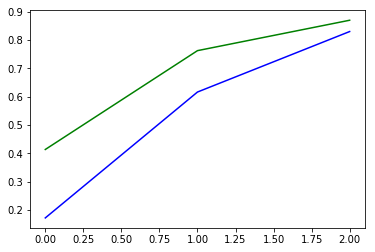

In [18]:
plt.figure()
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['val_loss'], 'g')
plt.show()

plt.figure()
plt.plot(hist.history['acc'], 'b')
plt.plot(hist.history['val_acc'], 'g')
plt.show()

In [19]:
a = encoder.predict(X)

In [20]:
w2v = {}
alpha = 0.9

for i in range(X.shape[0]):
    try:
        old_vec = w2v[vocabulary[y[i].argmax()]]
        new_vec = alpha*old_vec + (1-alpha)*a[i] # Running Average
        w2v[vocabulary[y[i].argmax()]] = new_vec
    except:
        w2v[vocabulary[y[i].argmax()]] = a[i]
print (len(w2v.keys()))

8756


In [21]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2)/np.sqrt((v1**2).sum()*(v2**2).sum())

In [42]:
v1 = w2v['sherlock']
v2 = w2v['holmes']
print(cosine_similarity(v1, v2))

0.340144
